In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 2.9 MB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 49.3 MB/s 
     |████████████████████████████████| 636 kB 39.8 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 109 kB 52.1 MB/s 
     |████████████████████████████████| 546 kB 38.0 MB/s 
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [2]:
import pandas as pd

import sys
# For running via Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from bert_finetuner import *

In [3]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
#data = pd.read_json('https://raw.githubusercontent.com/pradeep-miriyala/multi-modal-bert-models/main/data/song_lyric_map.json?token=ADXRNFRS46PTRG46WUZLXHDBKH7HY')

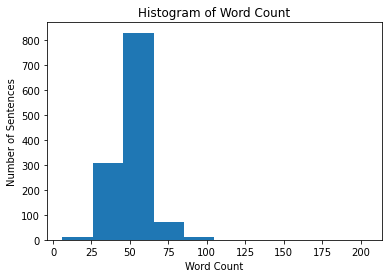

In [4]:
plot_histogram(data['Lyric'])

##### From the histogram, it is evident that most of the sentences have 50 words and some have 75. Although there are sentences with 100 words, the perecentage is very minimal. Hence maximum sequence length is considered as 75.

In [5]:
MAX_SEQ_LEN = 75
gpu, cpu = get_devices()

In [6]:
chk_point = 'bert-base-multilingual-cased'
base_model, tokenizer = load_bert_model(chk_point)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [7]:
sequences, attention_masks, targets = process_data_w_base_model(data, tokenizer, max_seq_len=MAX_SEQ_LEN)

In [8]:
txt_results = k_fold_model_preparation(base_model, gpu, data, sequences, attention_masks, targets, fusion=False,
                                       k_folds=2, epochs=15, balance_classes=True, dropout_level=0.25, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0)

Running Text Only Classification
FOLD 0
--------------------------------
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 15
Training Model
Evaluating
Losses - Train : 0.674 / Validation : 0.574
Epoch 2 / 15
Training Model


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Evaluating
Losses - Train : 0.602 / Validation : 0.550
Epoch 3 / 15
Training Model
Evaluating
Losses - Train : 0.558 / Validation : 0.593
Epoch 4 / 15
Training Model
Evaluating
Losses - Train : 0.538 / Validation : 0.603
Epoch 5 / 15
Training Model
Evaluating
Losses - Train : 0.480 / Validation : 0.522
Epoch 6 / 15
Training Model
Evaluating
Losses - Train : 0.428 / Validation : 0.541
Epoch 7 / 15
Training Model
Evaluating
Losses - Train : 0.486 / Validation : 0.585
Epoch 8 / 15
Training Model
Evaluating
Losses - Train : 0.399 / Validation : 0.527
Epoch 9 / 15
Training Model
Evaluating
Losses - Train : 0.385 / Validation : 0.755
Epoch 10 / 15
Training Model
Evaluating
Losses - Train : 0.337 / Validation : 0.565
Epoch 11 / 15
Training Model
Evaluating
Losses - Train : 0.400 / Validation : 0.778
Epoch 12 / 15
Training Model
Evaluating
Losses - Train : 0.343 / Validation : 0.771
Epoch 13 / 15
Training Model
Evaluating
Losses - Train : 0.294 / Validation : 0.732
Epoch 14 / 15
Training Model

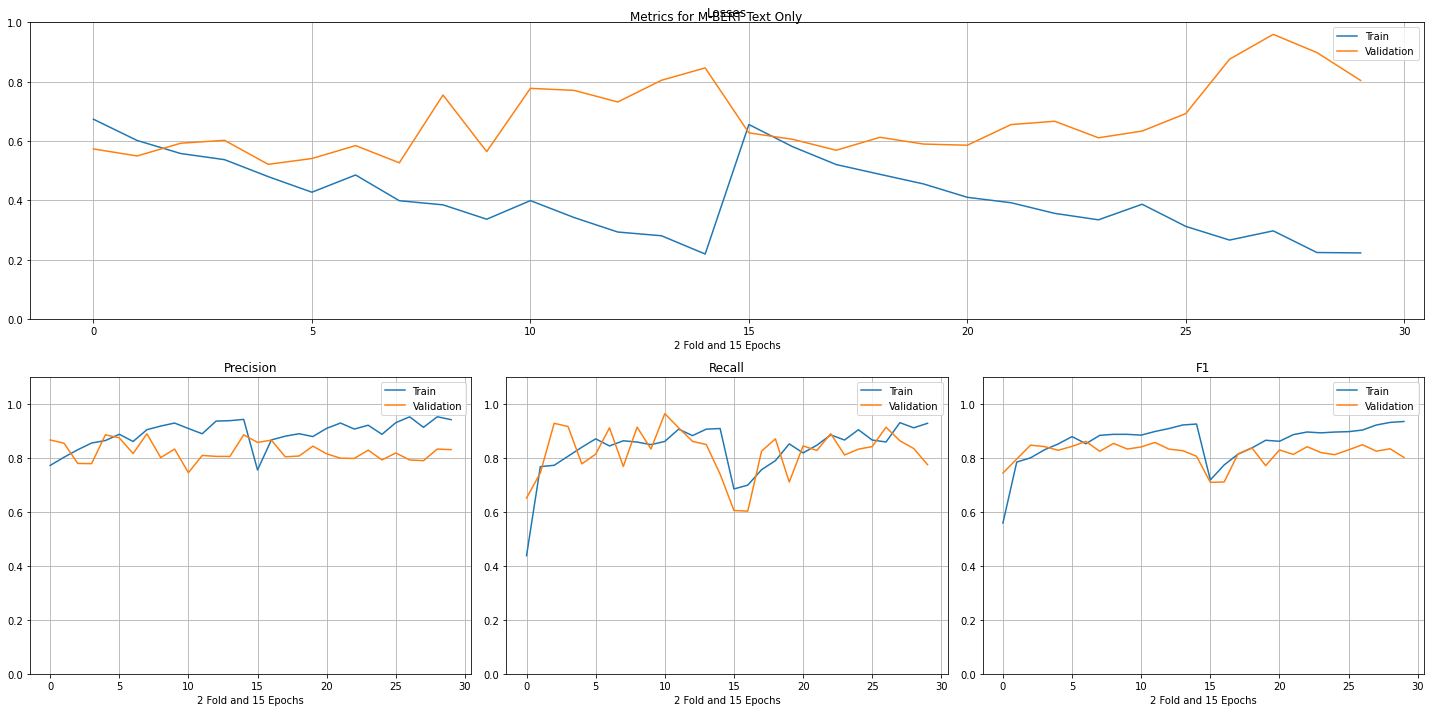

In [9]:
plot_results(txt_results, 'M-BERT Text Only')

In [10]:
fusion_results = k_fold_model_preparation(base_model, gpu, data, sequences, attention_masks, targets, fusion=True,
                                       k_folds=2, epochs=15, balance_classes=True, dropout_level=0.25, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0)

Running Fusion Model
FOLD 0
--------------------------------
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 15
Training Model
Evaluating
Losses - Train : 0.691 / Validation : 0.687
Epoch 2 / 15
Training Model


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Evaluating
Losses - Train : 0.671 / Validation : 0.608
Epoch 3 / 15
Training Model
Evaluating
Losses - Train : 0.601 / Validation : 0.576
Epoch 4 / 15
Training Model
Evaluating
Losses - Train : 0.599 / Validation : 0.713
Epoch 5 / 15
Training Model
Evaluating
Losses - Train : 0.629 / Validation : 0.578
Epoch 6 / 15
Training Model
Evaluating
Losses - Train : 0.583 / Validation : 0.547
Epoch 7 / 15
Training Model
Evaluating
Losses - Train : 0.547 / Validation : 0.548
Epoch 8 / 15
Training Model
Evaluating
Losses - Train : 0.525 / Validation : 0.506
Epoch 9 / 15
Training Model
Evaluating
Losses - Train : 0.490 / Validation : 0.541
Epoch 10 / 15
Training Model
Evaluating
Losses - Train : 0.515 / Validation : 0.511
Epoch 11 / 15
Training Model
Evaluating
Losses - Train : 0.486 / Validation : 0.505
Epoch 12 / 15
Training Model
Evaluating
Losses - Train : 0.473 / Validation : 0.530
Epoch 13 / 15
Training Model
Evaluating
Losses - Train : 0.465 / Validation : 0.489
Epoch 14 / 15
Training Model

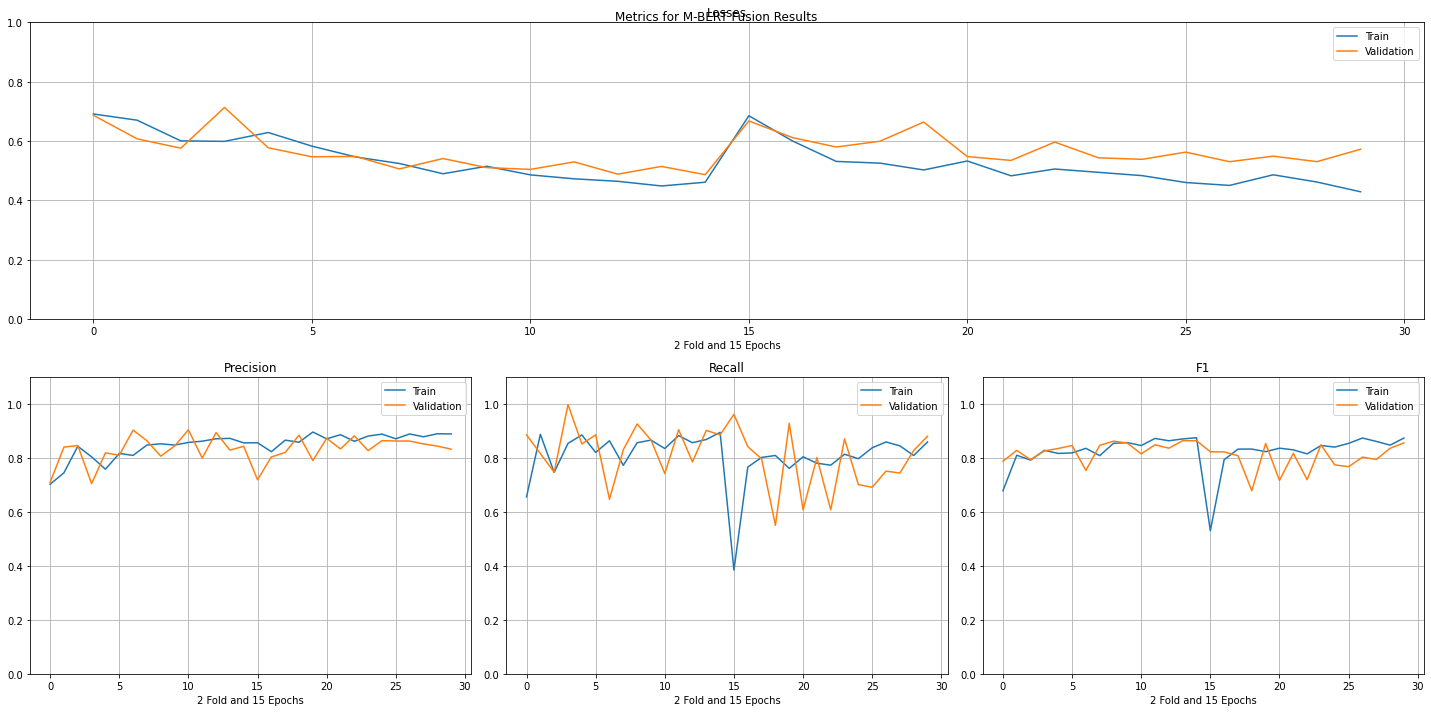

In [11]:
plot_results(fusion_results,'M-BERT Fusion Results')